<h1 align='center'>Clustering Geolocation Data Intelligently in Python</h1>
<h4 align='center'>- Chirag Sable</h4>

<br>



In this project, we will then learn how to visualize geolocation data clearly and interactively using Python. Also, we will learn a simple but limited approach to clustering this data, using the K-Means algorithm. We will develop on this notion of clustering by moving to more advanced density-based methods, namely Density-Based Spatial Clustering of Applications with Noise, known as DBSCAN, and in order to address some of its shortcomings, the more advanced Hierarchical DBSCAN (HDBSCAN). We will also learn about a simple method of addressing outliers that may exist in a clustering problem.

We have taxi rank locations, and want to define key clusters of these taxis where we can build service stations for all taxis operating in that region.


## Project Outline

<a href='#task1'>1. Exploratory Data Analysis</a><br>
<a href='#task2'>2. Visualizing Geographical Data</a><br>
<a href='#task3'>3. Clustering Strength / Performance Metric</a><br>
<a href='#task4'>4. K-Means Clustering</a><br>
<a href='#task5'>5. DBSCAN</a><br>
<a href='#task6'>6. HDBSCAN</a><br>
<a href='#task7'>7. Addressing Outliers</a><br>
<a href='#further'>Further Reading</a><br>


<br>

Import the required packages.

In [1]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

!pip install tqdm #installs tqdm package
from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive

from collections import defaultdict

!pip install hdbscan 
!pip install folium

import hdbscan
import folium
import re


cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

  Using cached https://files.pythonhosted.org/packages/22/2f/2423d844072f007a74214c1adc46260e45f034bb1679ccadfbb8a601f647/hdbscan-0.8.26.tar.gz
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/19/49/91ebe4a00bf894d08dd9680cd9dfb05936eb2848eebd9402b43885aa74cf/Cython-0.29.21-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/51/dd/0e015051b4a27ec5a58b02ab774059f3289a94b0906f880a3f9507e74f38/joblib-0.16.0-py3-none-any.whl
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan


<a id='task1'></a>
# 1. Exploratory Data Analysis

Load the data and view it.

In [2]:
df = pd.read_csv('Data/taxi_data.csv')

In [3]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

Check and remove duplicate **LON** and **LAT** values.

In [4]:
df.duplicated(subset=['LON','LAT']).values.any()

True

In [5]:
df.isna().values.any()

True

In [6]:
print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')
df.dropna(inplace=True)
df.drop_duplicates(subset=['LON','LAT'], keep='first',inplace=True)
print(f'After dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

Before dropping NaNs and dupes	:	df.shape = (838, 3)
After dropping NaNs and dupes	:	df.shape = (823, 3)


In [7]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

Convert into `np.array`

In [8]:
X = np.array(df[['LON','LAT']],dtype='float64')

Let's visualize the scatter plot.

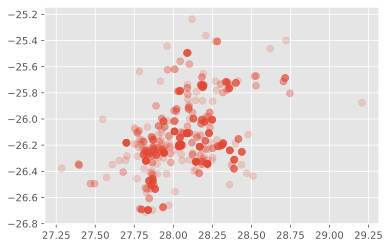

In [9]:
plt.scatter(X[:,0], X[:,1], alpha=0.2, s=50)

<a id='task2'></a>
# 2. Visualizing Geographical Data


Let us create a Folium map.

In [10]:
m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, 
               tiles='Stamen Toner')

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row.LAT, row.LON],
        radius=5,
        popup=re.sub(r'[^a-zA-Z ]+', '', row.NAME),
        color='#1787FE',
        fill=True,
        fill_colour='#1787FE'
    ).add_to(m)

In [11]:
m

<br>

<a id='task3'></a>
# 3. Clustering Strength / Performance Metric

In [12]:
X_blobs, _ = make_blobs(n_samples=1000, centers=10, n_features=2, 
                        cluster_std=0.5, random_state=4)

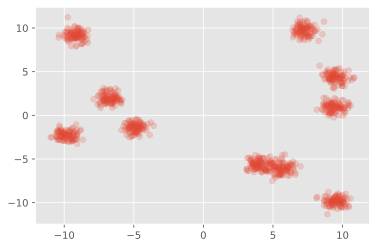

In [13]:
plt.scatter(X_blobs[:,0], X_blobs[:,1], alpha=0.2)

In [14]:
class_predictions = np.load('Data/sample_clusters.npy')

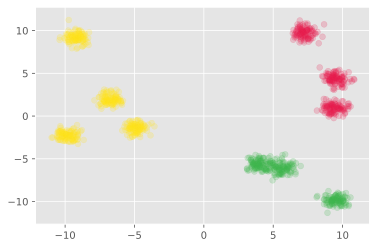

In [15]:
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster])

In [16]:
silhouette_score(X_blobs, class_predictions)

0.6657220862867241

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. 

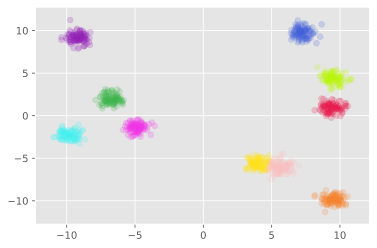

In [17]:
class_predictions = np.load('Data/sample_clusters_improved.npy')
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster])

In [18]:
silhouette_score(X_blobs, class_predictions)

0.7473587799908298

<a id='task4'></a>
# 4. K-Means Clustering

In [19]:
X_blobs, _ = make_blobs(n_samples=1000, centers=50, 
                        n_features=2, cluster_std=1, random_state=4)

In [20]:
data = defaultdict(dict)
for x in range(1,21):
    model = KMeans(n_clusters=3, random_state=17, 
                   max_iter=x, n_init=1).fit(X_blobs)
    
    data[x]['class_predictions'] = model.predict(X_blobs)
    data[x]['centroids'] = model.cluster_centers_
    data[x]['unique_classes'] = np.unique(class_predictions)

In [21]:
def f(x):
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']

    for unique_class in unique_classes:
            plt.scatter(X_blobs[class_predictions==unique_class][:,0], 
                        X_blobs[class_predictions==unique_class][:,1], 
                        alpha=0.3, c=cols[unique_class])
    plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
    plt.ylim([-15,15]); plt.xlim([-15,15])
    plt.title('How K-Means Clusters')

interactive_plot = interactive(f, x=(1, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=10, description='x', max=20, min=1), Output(layout=Layout(height='350px'…

In [22]:
X = np.array(df[['LON', 'LAT']], dtype='float64')
k = 70
model = KMeans(n_clusters=k, random_state=17).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans{k}'] = class_predictions

In [23]:
df.head()

LON       LAT                          NAME  CLUSTER_kmeans70
0  28.17858 -25.73882         11th Street Taxi Rank                 1
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank                 1
2  27.83239 -26.53722          Adams Road Taxi Rank                 9
3  28.12514 -26.26666  Alberton City Mall Taxi Rank                 8
4  28.10144 -26.10567      Alexandra Main Taxi Rank                 4

In [24]:
def create_map(df, cluster_column):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

    for _, row in df.iterrows():

        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location= [row['LAT'], row['LON']],
            radius=5,
            popup= folium.Popup(row[cluster_column]), ##
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
        
    return m

m = create_map(df, 'CLUSTER_kmeans70')
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('kmeans_70.html')

K=70
Silhouette Score: 0.6527069281188838


In [25]:
best_silhouette, best_k = -1, 0

for k in tqdm(range(2, 100)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
        
print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}') 

100%|██████████| 98/98 [06:56<00:00,  4.25s/it]

K=99
Silhouette Score: 0.7084996241477046


<a id='task5'></a>
# 5. DBSCAN 
Density-Based Spatial Clustering of Applications with Noise

In [26]:
# code for indexing out certain values
dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1])

new = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(dummy)])

In [27]:
model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions = model.labels_

df['CLUSTERS_DBSCAN'] = class_predictions

In [28]:
m = create_map(df, 'CLUSTERS_DBSCAN')


print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 51
Number of outliers found: 289
Silhouette ignoring outliers: 0.9232138250288208
Silhouette outliers as singletons: 0.5667489350583482


In [29]:
m

<a id='task6'></a>
# 6. HDBSCAN
Hierarchical DBSCAN

In [30]:
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, 
                        cluster_selection_epsilon=0.01)

class_predictions = model.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions

In [31]:
m = create_map(df, 'CLUSTER_HDBSCAN')


print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

m

Number of clusters found: 66
Number of outliers found: 102
Silhouette ignoring outliers: 0.7670504356844786
Silhouette outliers as singletons: 0.638992483305273


In [32]:
hdbscan.HDBSCAN?

Init signature:
hdbscan.HDBSCAN(
    min_cluster_size=5,
    min_samples=None,
    cluster_selection_epsilon=0.0,
    metric='euclidean',
    alpha=1.0,
    p=None,
    algorithm='best',
    leaf_size=40,
    memory=Memory(location=None),
    approx_min_span_tree=True,
    gen_min_span_tree=False,
    core_dist_n_jobs=4,
    cluster_selection_method='eom',
    allow_single_cluster=False,
    prediction_data=False,
    match_reference_implementation=False,
    **kwargs,
)
Docstring:     
Perform HDBSCAN clustering from vector array or distance matrix.

HDBSCAN - Hierarchical Density-Based Spatial Clustering of Applications
with Noise. Performs DBSCAN over varying epsilon values and integrates
the result to find a clustering that gives the best stability over epsilon.
This allows HDBSCAN to find clusters of varying densities (unlike DBSCAN),
and be more robust to parameter selection.

Parameters
----------
min_cluster_size : int, optional (default=5)
    The minimum size of clusters; sin

<a id='task7'></a>
# 7. Addressing Outliers


In [33]:
classifier = KNeighborsClassifier(n_neighbors=1)

In [34]:
df_train = df[df.CLUSTER_HDBSCAN!=-1]
df_predict = df[df.CLUSTER_HDBSCAN==-1]

In [35]:
X_train = np.array(df_train[['LON','LAT']], dtype='float64')
y_train = np.array(df_train['CLUSTER_HDBSCAN'])

X_predict = np.array(df_predict[['LON','LAT']], dtype='float64')

In [36]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [37]:
predictions = classifier.predict(X_predict)

In [38]:
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN']

In [39]:
df.loc[df.CLUSTER_HDBSCAN==-1, 'CLUSTER_hybrid'] = predictions

In [40]:
m = create_map(df, 'CLUSTER_hybrid')

In [41]:
m

In [42]:
class_predictions = df.CLUSTER_hybrid
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')

Number of clusters found: 66
Silhouette: 0.5849126494706486


Text(0.5, 0, 'Cluster Sizes')

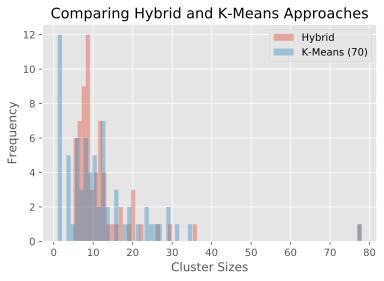

In [43]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=70, alpha=0.4, 
                                              label='Hybrid')

df['CLUSTER_kmeans70'].value_counts().plot.hist(bins=70, alpha=0.4, 
                                              label='K-Means (70)')
plt.legend()
plt.title('Comparing Hybrid and K-Means Approaches')
plt.xlabel('Cluster Sizes')

<a id='further'></a>
# Further Reading

For some additional reading, feel free to check out [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), and [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/) clustering respectively.

It may be of use to also check out [other forms of clustering](https://scikit-learn.org/stable/modules/clustering.html) that are commonly used and available in the scikit-learn library. HDBSCAN documentation also includes [a good methodology](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html) for choosing your clustering algorithm based on your dataset and other limiting factors.